In [1]:
import numpy as np
import os as os
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import sklearn.utils as skutils
import sklearn.metrics as skmetrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import pickle
from tensorflow import keras
from tensorflow.keras import layers
import warnings
warnings.filterwarnings("ignore")

#setting up dataset paths
base_path = r"C:\Users\Mehrab\test\Kaggle_project_data\drug_MoAs"
save_path = r"C:\Users\Mehrab\test\Kaggle_projects\drug_MoAs"
train_features_path = os.path.join(base_path, 'train_features.csv')
train_targets_path = os.path.join(base_path, 'train_targets_scored.csv')
train_targets_nonscored_path = os.path.join(base_path, 'train_targets_nonscored.csv')

#reading in datasets
train_features = pandas.read_csv(train_features_path)
train_targets = pandas.read_csv(train_targets_path)
train_targets_nonscored = pandas.read_csv(train_targets_nonscored_path)

<br /><br />
**Inspecting data manually**
<br /><br />
**Features**

In [2]:
#summarising ctrl, treatment data separately for manual/visual inspection
#with actual drug treatments
train_features[train_features['cp_type'].str.contains('trt_cp')].describe()

#random col histograms
#r_cols = tuple(np.random.randint(0, high = train_features.shape[1], size = 6))
#curr_cols = train_features.keys()[[r_cols]]
#train_features[train_features['cp_type'].str.contains('trt_cp')].hist(curr_cols)

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,...,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000,21948.000000
mean,48.015309,0.277675,-0.079845,0.168391,0.081265,0.084974,-0.143382,0.012126,-0.204332,-0.239865,...,-0.522921,-0.511895,-0.557992,-0.565939,-0.573176,-0.400426,-0.516135,-0.424148,-0.534623,-0.349560
std,19.403896,1.427121,0.801954,1.035796,0.955117,1.023297,1.183272,0.871004,1.136824,1.800194,...,2.064286,2.110222,2.066065,2.172713,2.225600,1.676732,2.126325,1.753232,1.888704,1.442178
min,24.000000,-5.513000,-5.737000,-5.975000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.460925,-0.534425,-0.425400,-0.429000,-0.438000,-0.607500,-0.509500,-0.501500,-0.546750,...,-0.598550,-0.591625,-0.610925,-0.606850,-0.595800,-0.600125,-0.583450,-0.587825,-0.648525,-0.594625
50%,48.000000,0.000000,-0.034350,0.089950,0.003450,-0.013200,-0.017950,-0.028300,-0.006400,-0.021550,...,-0.031050,-0.011650,-0.017900,-0.046800,-0.032600,-0.032500,-0.019600,-0.027200,-0.018800,-0.047250
75%,72.000000,0.533925,0.410450,0.679150,0.458450,0.467525,0.504550,0.486950,0.407025,0.514300,...,0.440600,0.447900,0.439300,0.422350,0.442550,0.427200,0.451325,0.428800,0.431450,0.406775
max,72.000000,10.000000,5.033000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [3]:
#vehicle control rows
#summary table
train_features[train_features['cp_type'].str.contains('ctl_vehicle')].describe()

#histograms for same random set of columns as above
#train_features[train_features['cp_type'].str.contains('ctl_vehicle')].hist(curr_cols)

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,1866.00000,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000,...,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000,1866.000000
mean,48.07717,-0.096364,-0.281979,-0.037559,0.090283,-0.267603,-0.085360,0.316310,-0.182888,0.395450,...,0.162114,0.132396,0.012933,0.273761,0.270180,0.195568,0.155791,0.161715,0.286888,0.263716
std,19.39510,0.833248,0.905735,1.016181,0.887971,1.078825,1.131637,0.963718,0.982525,0.767979,...,0.720884,0.693152,0.792459,0.698417,0.777186,0.694797,0.740021,0.754283,0.620762,0.698150
min,24.00000,-4.859000,-3.341000,-9.104000,-2.568000,-5.805000,-10.000000,-4.981000,-4.342000,-4.064000,...,-5.092000,-4.336000,-5.897000,-4.418000,-4.730000,-5.402000,-4.883000,-5.683000,-3.321000,-3.815000
25%,24.00000,-0.639000,-0.879675,-0.589150,-0.434450,-0.906775,-0.530775,-0.213975,-0.794875,-0.095325,...,-0.256450,-0.275250,-0.372200,-0.129200,-0.156150,-0.190550,-0.271600,-0.238100,-0.091450,-0.149025
50%,48.00000,-0.132650,-0.242550,-0.089950,0.059500,-0.297200,0.020400,0.339700,-0.186000,0.367800,...,0.203500,0.196000,0.090350,0.333000,0.346150,0.230100,0.188950,0.211200,0.344350,0.315150
75%,72.00000,0.408800,0.320075,0.489725,0.525775,0.416800,0.570675,0.904050,0.499475,0.843075,...,0.653200,0.602300,0.523325,0.717425,0.768900,0.638000,0.616850,0.663875,0.711075,0.746125
max,72.00000,4.670000,5.039000,6.000000,10.000000,5.543000,4.304000,4.911000,3.383000,5.615000,...,2.193000,2.582000,2.330000,2.335000,2.752000,2.434000,2.368000,2.152000,1.912000,2.233000


Obs1: Distributions of trt_cp features are broader than ctl_vehicle, but only slightly. ie. Each treatment probably affects only a sparse subset of features, and so the distribution of feature values across treatments has sparse useful information. <br /><br /><br /><br />
Next, looking for feature redundancies

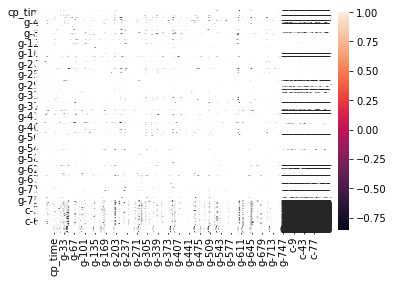

In [30]:
#Manual inspection part2
#plotting correlation matrix only for treatment rows

#Un-comment the rows below to re-compute corr matrix - took > 10 min on my laptop
#corr_mat = train_features[train_features['cp_type'].str.contains('trt_cp')].corr()  #this contains corr vals of non-categorical columns
#sns.heatmap(corr_mat, annot=True)
#plt.show()

Obs2: The c-xxx features are very un-correlated with each other. The g-xxx features tend to be highly correlated and redundant. This is consistent with obs1.
Will create a new feature matrix with the first n Principal Components of the g-xxx feature columns, while retaining all the c-xxx features. This will make the dataset much easier to use. (Should run a test version without the original g-xxx features or by retaining g-xxx in addition to the PCs)
<br /><br /><br /><br />
**Pre-processing feature matrix: Normalizing and then computing PCs**

In [30]:
#Splitting data before doing any pre-processing
train_features_orig = train_features
#train_features = pandas.get_dummies(train_features_orig, dummy_na = False)  #converting times and dosages to one-hot columns
X_train, X_valid, y_train, y_valid = train_test_split(train_features, train_targets, test_size = 0.33, random_state = 8)

#dropping ID column
ID_train = X_train['sig_id']
ID_valid = X_valid['sig_id']
X_train = X_train.drop(['sig_id'], axis = 1)
X_valid = X_valid.drop(['sig_id'], axis = 1)

X_train = pandas.get_dummies(X_train, dummy_na = False)  #converting trt/ctrl and dosages to one-hot columns
X_valid = pandas.get_dummies(X_valid, dummy_na = False)  #converting trt/ctrl and dosages to one-hot columns

#Z-scoring
X_train_z = (X_train - X_train.mean()) / X_train.std()
X_valid_z = (X_valid - X_train.mean()) / X_train.std()   #using training set mean, std to prevent info leakage

#computing first 180 PCs for g-xxx features
g_xx_train = X_train_z.loc[:,X_train_z.columns.str.startswith('g-')]
n_PCs = 45    #determined manually after trying a few numbers 
pca_obj = PCA(n_components = n_PCs)
pca_obj.fit(g_xx_train)    #This fitted object contains the feature weights needed to project into PC space

PCA(n_components=45)

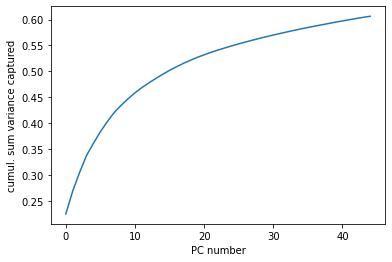

In [31]:
#Assessing if n components are enough - arbitrarily decided I need to capture 75% of variance, capturing 77% with 180 PCs
vars = pca_obj.explained_variance_ratio_
fig, (ax1) = plt.subplots()
vars = np.cumsum(vars)
plt.plot(vars)

ax1.set_xlabel('PC number')
ax1.set_ylabel('cumul. sum variance captured')

#computing PC projections of g-xx columns
g_xx_train = X_train_z.loc[:,X_train_z.columns.str.startswith('g-')]
PCs_train = pca_obj.transform(g_xx_train)
col_names = ['g-PC' + str(num) for num in range(n_PCs)]
PCs_train = pandas.DataFrame(PCs_train, columns = col_names)  #PC values converted to a dataframe

g_xx_valid = X_valid_z.loc[:,X_valid_z.columns.str.startswith('g-')]
PCs_valid = pca_obj.transform(g_xx_valid)
PCs_valid = pandas.DataFrame(PCs_valid, columns = col_names)  #PC values converted to a dataframe

#replacing g-xx columns with PC-projected columns
g_indices = np.where(X_train_z.columns.str.startswith('g-'))
X_train_z = X_train_z.drop(X_train_z.iloc[:, g_indices[0]], axis = 1)  #removed g-xx columns


#These lines ensure pandas.concat doesn't try to re-arrange rows based on indices
X_train_z.reset_index(drop=True, inplace=True)
X_valid_z.reset_index(drop = True, inplace = True)
PCs_train.reset_index(drop=True, inplace=True)
PCs_valid.reset_index(drop=True, inplace=True)

X_train_PCs = pandas.concat( [X_train_z, PCs_train], axis = 1)    #added on PC projections of g-xx columns

X_valid_z = X_valid_z.drop(X_valid_z.iloc[:, g_indices[0]], axis = 1)  #removed g-xx columns
X_valid_PCs = pandas.concat([X_valid_z, PCs_valid], axis = 1)     #added on PC projections of g-xx columns

In [32]:
#sanity-checking for issues with dataframe merge, cleanliness of data. n_nans should be 0.
n_nans = X_train_PCs.isna()
n_nans = sum(n_nans.sum())
print(n_nans)

0


<br /><br /><br /><br />
**Manually inspecting targets**

Text(0, 0.5, 'counts')

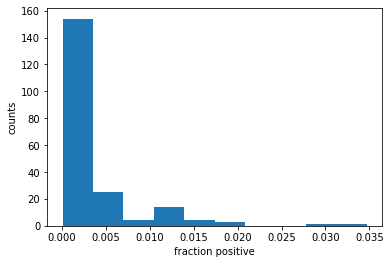

In [33]:
pos_target_fracs = y_train.mean(numeric_only = True)
fig, (ax1) = plt.subplots()
plt.hist(pos_target_fracs)

ax1.set_xlabel('fraction positive')
ax1.set_ylabel('counts')

The target matrix is very sparse. Binary, MoA targets are mostly 0, with a fraction of 1 <0.5% for most. Even the most frequently detected MoA is 1 for < 3% or treatments. These frequencies will be used to create a random predictor to use as a baseline for the effectiveness of the trained model. 
<br /><br /><br /><br />
**Next, checking how often a given treatment is positive for > 1 MoA target ie. How independent are MoAs?**

Text(0, 0.5, 'counts')

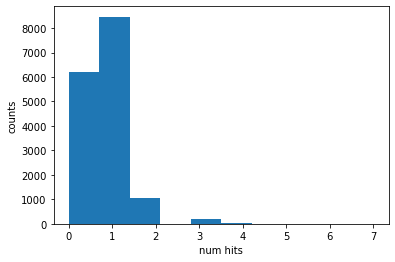

In [34]:
all_hits_vec = y_train.sum(axis = 1, numeric_only = True)

fig, (ax1) = plt.subplots()
plt.hist(all_hits_vec)

ax1.set_xlabel('num hits')
ax1.set_ylabel('counts')

Over half the treatment rows have a hit on at least one MoA. About 5% have 2 hits and very few have > 2 hits. This means there isn't much interaction between target MoAs and we could probably get away with independently predicting each MoA as a first pass model.
<br /><br /><br /><br />
**Computing baseline performance of a randomly predicting model to use as a benchmark**

In [35]:
#A random predictor with identical statistics to the real Target data is obtained by shuffling Target set rows:
yhat_train = y_train.sample(frac = 1.0)
yhat_valid = y_valid.sample(frac = 1.0)


#Computing accuaracies
#Approach1: Ignore multiple MoA hits and predict at most 1 MoA per row. Under this assumption, we can treat target matrices as one-hot encodings of the target MoA.
#inverting the one-hot encoded target matrix to give a vector of MoA numbers - this assumes only one MoA can be found per treatment
def process_y_matrix_onehot(y_matrix):
    y_data = y_matrix.iloc[:, 1:]   #getting rid of the mol-id column
    y_data = y_data.assign(dummy = [0.5] * y_data.shape[0])   #adding a dummy row set to 0.5. This will capture rows with no target MoA

    #replacing MoA names with indices as dataframe keys
    MoA_names = list(y_data.keys())
    name_dict = {}
    count = 1
    for name in MoA_names: 
        name_dict[name] = count
        count = count + 1

    y_data = y_data.rename(columns = name_dict)
    y_data = y_data.idxmax(1)
    return y_data

def compute_onehot_accuracy(y_hat_vec, y_vec):
    diffs = y_hat_vec.to_numpy() - y_vec.to_numpy()
    onehot_acc = sum(diffs == 0)  #absolute number of incorrectly predicted MoAs
    onehot_acc = onehot_acc/y_vec.shape[0]   #fraction of incorrectly predicted MoAs
    return onehot_acc



#Pre-processing real target data
y_train_data = process_y_matrix_onehot(y_train)
y_valid_data = process_y_matrix_onehot(y_valid)

yhat_train_data = process_y_matrix_onehot(yhat_train)
yhat_valid_data = process_y_matrix_onehot(yhat_valid)

acc_train = compute_onehot_accuracy(yhat_train_data, y_train_data)
acc_valid = compute_onehot_accuracy(yhat_valid_data, y_valid_data)

print('training set random predictor acc. = ' + str(acc_train))
print('valid set random predictor acc. = ' + str(acc_valid))



training set random predictor acc. = 0.15549984330930744
valid set random predictor acc. = 0.17012342537218475


<br /><br /><br /><br />
**Building first model - multi-class logisitic regression, one vs many ie. a stack of logistic regressors**

In [36]:
#checking if a model has already been trained before training afresh (unless forced to retrain)
model_name = 'logreg_model_45PC_Cpoint00005'

force_retrain = False
if os.path.isfile(save_path + model_name + '.pickle') == False or force_retrain == True:
    #Specifying, training model
    model = LogisticRegression(random_state=0, class_weight = 'balanced', multi_class = 'ovr', verbose = 1, solver = 'liblinear', C = 0.00005).fit(X_train_PCs, y_train_data)

    #serialising and saving to disk.
    with open(save_path + model_name + '.pickle', 'wb') as f:
        pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
else:
    with open(save_path + model_name + '.pickle', 'rb') as f:
        model = pickle.load(f)

    
    
        

[LibLinear]

In [37]:
y_hat = model.predict(X_train_PCs)
diffs = y_hat - y_train_data
train_acc = sum(diffs == 0)
train_acc = train_acc/y_train_data.shape[0]
print('training data accuracy = ' + str(train_acc))

y_hat = model.predict(X_valid_PCs)
diffs = y_hat - y_valid_data
valid_acc = sum(diffs == 0)
valid_acc = valid_acc/y_valid_data.shape[0]
print('validation data accuracy = ' + str(valid_acc))


training data accuracy = 0.4045126919460984
validation data accuracy = 0.41010306654790685


<br /><br />
Notes: The model is better than random at predicting MoAs. But it is clearly over-fitting. Here are some obvious ways to follow up:
1. re-train model with a larger regularization constant.
2. play with the number of PCs to include to make the input features richer, or quicker to compute
3. Use an SVM model - it will probably train much more quickly and might perform better since the input feature space is so high-dimensional.
4. Once we fix over-fitting and get higher accuracies with the one-hot assumption, start trying to predict up to two MoAs - probably by making an output vector that is 2x as long. This would be able to capture >95% of target vector cases.

In [26]:
a = pandas.DataFrame({'A': [1, 2, 3], 'B':[4, 5, 6]})
a

,A,B
0,1,4
1,2,5
2,3,6


In [32]:
b = a.sample(frac = 1.0)
b

,A,B
2,3,6
1,2,5
0,1,4


In [40]:
c = b.to_numpy()

In [41]:
c

array([[3, 6],
       [2, 5],
       [1, 4]], dtype=int64)